In [ ]:
using DataFrames, CSV, SparseArrays, LinearAlgebra, DataFramesMeta
include("../Code/Mixing/Mixing.jl")


In [ ]:
import Pkg; Pkg.add("DataFramesMeta")
using DataFrames, DataFramesMeta


In [ ]:
Pkg.add("CUDA")

In [ ]:
Pkg.add("BenchmarkTools")

In [ ]:
using DataFrames, CSV, SparseArrays, LinearAlgebra, BenchmarkTools, JuMP, MQLib


In [ ]:
using Plots

In [ ]:
p613test = CSV.read("../Datasets/MQLib/g000002.txt"
, header=2, DataFrame, delim=" ");

samplemaxcut =  CSV.read("../Datasets/MQLib/sampleMaxCut.txt"
, header=4, DataFrame, delim=" ");

G55 = CSV.read("../Datasets/MQLib/G55.txt"
    , comment="#", DataFrame, delim=" ",  header=false);


G56 = CSV.read("../Datasets/MQLib/G56.txt"
    , comment="#", DataFrame, delim=" ",  header=false);

In [564]:
allres = CSV.read("results.csv", DataFrame)

Row,timestamp,graphname,heuristic,seed,limit,objective
,String31,String31,String31,Int64,Float64,Float64
1,2016-07-10 02:29:35.069644,g000512.zip,BURER2002,144,0.048804,35264.0
2,2016-07-10 02:29:35.393688,g000512.zip,BURER2002,244,0.048804,35287.0
3,2016-07-10 02:29:34.388826,g002037.zip,BURER2002,144,0.003209,4.55959e7
4,2016-07-10 02:29:35.480032,g002037.zip,BURER2002,244,0.003209,4.55959e7
5,2016-07-10 02:29:35.486949,g000512.zip,BURER2002,344,0.048804,35265.0
6,2016-07-10 02:29:35.525564,g002037.zip,BURER2002,344,0.003209,4.54558e7
7,2016-07-10 02:29:35.577306,g002037.zip,BURER2002,444,0.003209,4.55959e7
8,2016-07-10 02:29:35.589604,g000512.zip,BURER2002,444,0.048804,35296.0
9,2016-07-10 02:29:35.618556,g002037.zip,BURER2002,544,0.003209,4.55959e7


In [402]:
function matrixFromFile(readfile)
    M = zeros(readfile[1,1], readfile[1,1])
    for i in 2:nrow(readfile)
        M[readfile[i,1], readfile[i,2]] = -readfile[i,3]
        M[readfile[i,2], readfile[i,1]] = -readfile[i,3]

        
    end

    toRemove = findall(x->x==0, sum(abs.((M)), dims=1))
    toRemove = [el[2] for el in toRemove]
    M = M[1:end .∉ [toRemove], 1:end .∉ [toRemove]]
    
    return M
end

matrixFromFile (generic function with 1 method)

In [474]:
function matrixFromFileNoR(readfile)
    M = zeros(readfile[1,1], readfile[1,1])
    for i in 2:nrow(readfile)
        M[readfile[i,1], readfile[i,2]] = -readfile[i,3]
        M[readfile[i,2], readfile[i,1]] = -readfile[i,3]

        
    end

    return M
end

matrixFromFileNoR (generic function with 1 method)

In [295]:
[1,2] .∉ [tR]

2-element BitVector:
 1
 1

In [296]:
M = matrixFromFile(G55)

4969×4969 Matrix{Float64}:
  0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  -1.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0 

In [297]:
[el[2] for el in tR]

31-element Vector{Int64}:
  233
  619
  666
  733
 1675
 1919
 2138
 2178
 2254
 2275
 2285
 2556
 2597
    ⋮
 3588
 3820
 3864
 3920
 4391
 4416
 4468
 4502
 4704
 4735
 4765
 4950

In [298]:
M = matrixFromFile(G55)

4969×4969 Matrix{Float64}:
  0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  -1.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0   0.0 

In [299]:
sum(sparse(matrixFromFile(G55)))

-24996.0

In [300]:
matrixFromFile(p613test)

200×200 Matrix{Float64}:
    0.0   -179.0      0.0      0.0  …     0.0      0.0      0.0      0.0
 -179.0      0.0  -1173.0      0.0        0.0      0.0      0.0      0.0
    0.0  -1173.0      0.0  -1261.0        0.0      0.0      0.0      0.0
    0.0      0.0  -1261.0      0.0        0.0      0.0      0.0      0.0
    0.0      0.0      0.0   -250.0        0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0  …     0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0        0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0        0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0        0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0        0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0  …     0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0        0.0      0.0      0.0      0.0
    0.0      0.0      0.0      0.0        0.0      0.0      0.0      0.0
    ⋮                     

In [338]:
function testpipeline(testinput)
    testmat = matrixFromFile(testinput)
    sparsetestmat=sparse(testmat)
    @time V = Mixing.randserial(length(sparsetestmat[1,:]), 20, sparsetestmat)
    Cost = tr(V* testmat* V')
  #  a100 = Mixing.assign100(V, sparsetestmat)
    print("Final Cost: ", Cost)#, " Best: ",max(a100...), " Average: ", sum(a100)/100)
    return V
end

testpipeline (generic function with 1 method)

In [302]:
V,costs = Mixing.randserial(length(sparse(matrixFromFile(p613test))[1,:]), 20, sparse(matrixFromFile(p613test)), .1, true)

([0.2251393271185204 0.21067233482400968 … 0.16080982749051753 0.16256424746421297; 0.24998232627596806 0.2549284488184435 … 0.22938163799268194 0.2336072197737181; … ; 0.22176765496432427 0.2002201846080998 … 0.22044574801846206 0.21836141681725327; 0.26170531369118616 0.26004969356870106 … 0.25905505784402166 0.25571854699083574], Any[-514686.6136406859, -514963.8306560733, -515194.2717198756, -515451.5631038837, -515631.2202158696, -515722.4425646721, -515834.89232272876, -516045.5341869368, -516065.486572111, -516153.4573682797  …  -550710.8787970964, -550710.9380930725, -550710.9383119261, -550710.9383119261, -550710.9442878711, -550710.9522112731, -550710.9522112731, -550710.9547982573, -550710.9691080473, -550710.9691080473])

In [303]:
costs[end]

-550710.9691080473

In [304]:
Mixing.assign100(V, (sparse(matrixFromFile(p613test))))

100-element Vector{Any}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [305]:
sign.(rand(20)' * V)

1×200 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

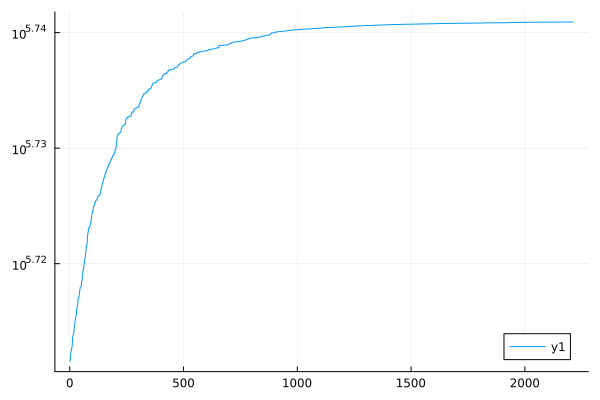

In [306]:
plot(-costs[1:end], yscale=:log10)

In [307]:
costs[end]

-550710.9691080473

In [308]:
testpipeline(p613test)


  0.030699 seconds (225.85 k allocations: 29.541 MiB, 6.04% compilation time)
Final Cost: -550906.656520191

In [309]:
L,C = Mixing.randserial(length(sparse(matrixFromFile(G55))[1,:]), 20, sparse(matrixFromFile(G55)), 1e-7, true)

([0.2248997488027742 0.22483129083848447 … 0.22500159509226889 0.22484769742960545; 0.2233805391926819 0.2234040862362306 … 0.22359677178550516 0.2234142658439377; … ; 0.22661718069320097 0.22649366976532648 … 0.22633177005467559 0.2265339689149306; 0.2237703477955446 0.22367966892744753 … 0.22385475118669196 0.22357385855165532], Any[-24131.036512349256, -24131.202871424965, -24131.436050565622, -24131.731483122712, -24131.88392672504, -24132.001577703984, -24132.09326645681, -24132.211297952468, -24132.31246062777, -24132.385230729626  …  -24995.994708488313, -24995.994708489685, -24995.994708489685, -24995.994708489685, -24995.99470849097, -24995.99470849097, -24995.99470851074, -24995.99470851075, -24995.99470851075, -24995.99470851075])

In [310]:
function f(x)
    if isnan(x)
        return 0.0
    else
        return x
    end
end

f (generic function with 1 method)

In [311]:
sum(isnan.(sum(L, dims=1)))

0

In [312]:
31*20

620

In [313]:
sum(isnan.(L))

0

In [314]:
findall(x->x==0, sum(abs.(matrixFromFile(G55)), dims=1))

CartesianIndex{2}[]

In [315]:
testpipeline(G55)

 37.017920 seconds (5.71 M allocations: 767.887 MiB, 0.21% gc time)
Final Cost: -24995.999999999996

In [316]:
for el in why
    println(el)
end

LoadError: UndefVarError: `why` not defined

In [ ]:
function testpipelineparallel(testinput)
    testmat = matrixFromFile(testinput)
    sparsetestmat=sparse(testmat)
    @time V = Mixing.randparallel(length(sparsetestmat[1,:]), 20, sparsetestmat)
    #a100 = Mixing.assign100(V, sparsetestmat)
    #print("Best: ",max(a100...), " Average: ", sum(a100)/100)
    Cost = tr(V* testmat* V')
    print("Final Cost: ", Cost)#, " Best: ",max(a100...), " Average: ", sum(a100)/100)
end

testpipelineparallel (generic function with 1 method)

In [ ]:
testpipelineparallel(p613test)

LoadError: UndefVarError: `Mixing` not defined

In [ ]:
Threads.nthreads()

1

In [ ]:
using JuMP

In [466]:
function MQLibpipelin(testinput)

    testmat = matrixFromFile(testinput)
    sparsetestmat=sparse(testmat)

    model = Model(MQLib.Optimizer)
    JuMP.set_optimizer_attribute(model, "heuristic", "ALKHAMIS1998")

    n,m = size(testmat)

    @variable(model, x[1:n], Bin)
    @objective(model, Min, (x)' * sparsetestmat *(x))

    time = @timed  optimize!(model)

    return time.time, objective_value(model)
end


MQLibpipelin (generic function with 1 method)

In [467]:
MQLibpipelin(G56)

▷ MQLib
▷ Heuristic: ALKHAMIS1998
┌────────┬─────────────┬──────────┐
│  iter  │    value    │   time   │
├────────┼─────────────┼──────────┤
│      1 │       0.000 │     5.00 │
│        │     168.000 │     1.00 │
│        │     238.000 │     1.00 │
│        │     406.000 │     1.00 │
│        │     550.000 │     1.00 │
│        │     614.000 │     1.00 │
│        │     662.000 │     1.00 │
│        │     718.000 │     1.00 │
│        │     962.000 │     1.00 │
│        │    1088.000 │     1.00 │
│        │    1206.000 │     1.00 │
│        │    1286.000 │     1.00 │
│        │    1356.000 │     1.00 │
│        │    1506.000 │     1.00 │
│        │    1560.000 │     1.00 │
│        │    1624.000 │     1.00 │
│        │    1642.000 │     1.00 │
│        │    1660.000 │     1.00 │
│        │    1692.000 │     1.00 │
│        │    1786.000 │     1.00 │
│        │    1916.000 │     1.00 │
│        │    2084.000 │     1.00 │
│        │    2228.000 │     1.00 │
│        │    2378.000 │     1

(1.108845666, -6272.0)

In [471]:
x = [0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1]


1×5000 Matrix{Int64}:
 0  1  1  0  0  0  0  1  0  1  0  0  1  …  0  0  1  1  1  1  1  0  0  1  0  1

In [479]:
x * matrixFromFileNoR(G56) * x'

1×1 Matrix{Float64}:
 -6184.0

In [529]:
V = testpipeline(G56)

 37.064227 seconds (5.71 M allocations: 767.971 MiB, 0.95% gc time)
Final Cost: -19166.588116625386

20×4969 Matrix{Float64}:
 -0.0213436    0.0620461   -0.34291    …   0.073156   -0.160407    0.33999
  0.063159    -0.00157512   0.0666881     -0.485049    0.114939    0.284895
  0.0115538    0.253303    -0.115456      -0.246021   -0.359      -0.0672426
 -0.0280927    0.392116     0.223775       0.0659892   0.174834    0.151543
  0.162114     0.0712798   -0.161415      -0.292109    0.0307874   0.156432
  0.175499     0.248223    -0.161619   …  -0.19574     0.0479633   0.00638905
 -0.259824     0.00380414  -0.120642      -0.0311192  -0.377985    0.120666
  0.0695546   -0.0359006    0.0529736      0.0180766   0.203968    0.00860675
  0.419        0.0359968   -0.07116       -0.122202   -0.205574    0.100648
 -0.570787    -0.260146    -0.300315       0.180798    0.239505    0.1414
 -0.232036    -0.0631763    0.592939   …   0.235577    0.139554    0.0446889
  0.0887032   -0.416198    -0.231094      -0.0189792  -0.182996   -0.0146874
 -0.143238    -0.200194     0.058545       0.0490096   0.02

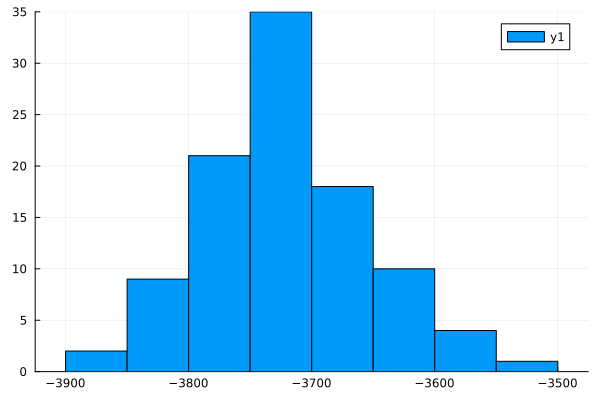

In [559]:
histogram(Mixing.assign100(V,  matrixFromFile(G56)))

In [462]:
@time MQLibpipelin(G55)

▷ MQLib
▷ Heuristic: ALKHAMIS1998
┌────────┬─────────────┬──────────┐
│  iter  │    value    │   time   │
├────────┼─────────────┼──────────┤
│      1 │       0.000 │    10.00 │
└────────┴─────────────┴──────────┘

  1.626022 seconds (1.72 M allocations: 669.466 MiB, 9.90% gc time, 11.02% compilation time)


(1.085079167, -24996.0)

In [ ]:
Mixing.assign(V, (sparse(matrixFromFile(samplemaxcut))))

2.0

In [433]:
L,C = Mixing.randserial(length(sparse(matrixFromFile(G55))[1,:]), 2, sparse(matrixFromFile(G55)), 1e-7, true)

([0.709555566788422 0.7084246992230379 … 0.7093295661073846 0.7087573840134725; 0.7046494856590483 0.7057864022002326 … 0.7048769868891376 0.705452316323633], Any[-24748.451158714917, -24748.451158714917, -24748.45842066969, -24748.469980277398, -24748.473946352882, -24748.488534371943, -24748.55188944391, -24748.56632545078, -24748.566773656778, -24748.566885724566  …  -24995.966863438203, -24995.966863440095, -24995.966863440095, -24995.966863442714, -24995.96686344279, -24995.96686344531, -24995.96686344531, -24995.966863445596, -24995.966863445596, -24995.96686351885])

In [434]:
C

76165-element Vector{Any}:
 -24748.451158714917
 -24748.451158714917
 -24748.45842066969
 -24748.469980277398
 -24748.473946352882
 -24748.488534371943
 -24748.55188944391
 -24748.56632545078
 -24748.566773656778
 -24748.566885724566
 -24748.572361645678
 -24748.572577104067
 -24748.57302807622
      ⋮
 -24995.96686050034
 -24995.96686342916
 -24995.966863438203
 -24995.966863440095
 -24995.966863440095
 -24995.966863442714
 -24995.96686344279
 -24995.96686344531
 -24995.96686344531
 -24995.966863445596
 -24995.966863445596
 -24995.96686351885

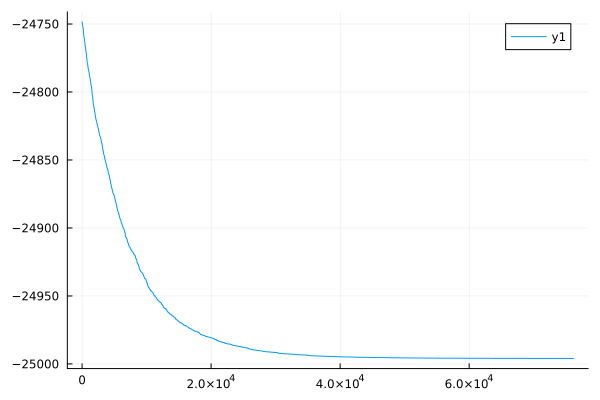

In [435]:
plot(C)

In [429]:
r = sign.(rand(20)' * L)

1×4969 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [400]:
sum(r)

-29.0

In [401]:
r * matrixFromFile(G55) * r'

1×1 Matrix{Float64}:
 -14232.0

In [ ]:
rand(20)' * V

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 -0.803602  -0.803602  0.803602

In [337]:
r = normalize(rand(100))
norm(r)

1.0

In [445]:
v = MQLib.show_heuristics()


ALKHAMIS1998:
  Simulated annealing
BASELINE:
  Baseline heuristic
BEASLEY1998SA:
  Simulated annealing
BEASLEY1998TS:
  Tabu search
BURER2002:
  Rank-2 relaxation of G-W algorithm, with local search
DESOUSA2013:
  Estimation of distribution algorithm
DUARTE2005:
  Genetic algorithm with VNS as local search
FESTA2002G:
  GRASP with local search
FESTA2002GPR:
  GRASP with path-relinking
FESTA2002GVNS:
  GRASP with VNS local search
FESTA2002GVNSPR:
  GRASP & VNS with path-relinking
FESTA2002VNS:
  VNS
FESTA2002VNSPR:
  VNS with path-relinking
GLOVER1998a:
  Tabu search
GLOVER2010:
  Tabu search with long-term memory
HASAN2000GA:
  Genetic algorithm
HASAN2000TS:
  Tabu search
KATAYAMA2000:
  Genetic algorithm with k-opt local search
KATAYAMA2001:
  Simulated annealing
LAGUNA2009CE:
  Cross-entropy method
LAGUNA2009HCE:
  Cross-entropy method with local search
LODI1999:
  Genetic algorithm
LU2010:
  Genetic algorithm with tabu search
MERZ1999CROSS:
  Genetic algorithm, with crossover only


In [443]:
v[1]

LoadError: MethodError: no method matching getindex(::Nothing, ::Int64)

In [448]:
allMQLib = ["ALKHAMIS1998", "BASELINE", "BEASLEY1998SA", "BEASLEY1998TS", "BURER2002", "DESOUSA2013", "DUARTE2005", "FESTA2002G", "FESTA2002GPR", "FESTA2002GVNS", "FESTA2002GVNSPR", "FESTA2002VNS", "FESTA2002VNSPR", "GLOVER1998a", "GLOVER2010", "HASAN2000GA", "HASAN2000TS", "KATAYAMA2000", "KATAYAMA2001", "LAGUNA2009CE", "LAGUNA2009HCE", "LODI1999", "LU2010", "MERZ1999CROSS", "MERZ1999GLS", "MERZ1999MUTATE", "MERZ2002GREEDY", "MERZ2002GREEDYKOPT", "MERZ2002KOPT", "MERZ2002ONEOPT", "MERZ2004", "PALUBECKIS2004bMST1", "PALUBECKIS2004bMST2", "PALUBECKIS2004bMST3", "PALUBECKIS2004bMST4", "PALUBECKIS2004bMST5", "PALUBECKIS2004bSTS", "PALUBECKIS2006", "PARDALOS2008"]

39-element Vector{String}:
 "ALKHAMIS1998"
 "BASELINE"
 "BEASLEY1998SA"
 "BEASLEY1998TS"
 "BURER2002"
 "DESOUSA2013"
 "DUARTE2005"
 "FESTA2002G"
 "FESTA2002GPR"
 "FESTA2002GVNS"
 "FESTA2002GVNSPR"
 "FESTA2002VNS"
 "FESTA2002VNSPR"
 ⋮
 "MERZ2002GREEDYKOPT"
 "MERZ2002KOPT"
 "MERZ2002ONEOPT"
 "MERZ2004"
 "PALUBECKIS2004bMST1"
 "PALUBECKIS2004bMST2"
 "PALUBECKIS2004bMST3"
 "PALUBECKIS2004bMST4"
 "PALUBECKIS2004bMST5"
 "PALUBECKIS2004bSTS"
 "PALUBECKIS2006"
 "PARDALOS2008"

In [455]:
function allMQLibpipelin(testinput)
    res=[]
    for heuristic in allMQLib
        testmat = matrixFromFile(testinput)
        sparsetestmat=sparse(testmat)

        model = Model(MQLib.Optimizer)
        JuMP.set_optimizer_attribute(model, "heuristic", heuristic)

        n,m = size(testmat)

        @variable(model, x[1:n], Bin)
        @objective(model, Min, (x)' * sparsetestmat *(x))

        time = @timed  optimize!(model)
        push!(res, (time.time, objective_value(model)))
    end

    return res
end


allMQLibpipelin (generic function with 1 method)

In [533]:
test = allMQLibpipelin(G56)

▷ MQLib
▷ Heuristic: ALKHAMIS1998
┌────────┬─────────────┬──────────┐
│  iter  │    value    │   time   │
├────────┼─────────────┼──────────┤
│      1 │       0.000 │     1.00 │
│        │      12.000 │     1.00 │
│        │     270.000 │     1.00 │
│        │     414.000 │     1.00 │
│        │     468.000 │     1.00 │
│        │     664.000 │     1.00 │
│        │     692.000 │     1.00 │
│        │     768.000 │     1.00 │
│        │     966.000 │     1.00 │
│        │    1036.000 │     1.00 │
│        │    1186.000 │     1.00 │
│        │    1232.000 │     1.00 │
│        │    1422.000 │     1.00 │
│        │    1498.000 │     1.00 │
│        │    1534.000 │     1.00 │
│        │    1630.000 │     1.00 │
│        │    1752.000 │     1.00 │
│        │    1824.000 │     1.00 │
│        │    2066.000 │     1.00 │
│        │    2098.000 │     1.00 │
│        │    2228.000 │     1.00 │
│        │    2342.000 │     1.00 │
│        │    2344.000 │     1.00 │
│        │    2390.000 │     1

39-element Vector{Any}:
 (1.147284167, -6274.0)
 (0.075562958, -5588.0)
 (1.172989125, -6274.0)
 (1.082588917, -5696.0)
 (1.090156458, -6104.0)
 (1.109327959, -520.0)
 (1.066456917, -6252.0)
 (1.160308, -6066.0)
 (1.068815541, -6250.0)
 (1.202856167, -6178.0)
 (1.200839667, -6224.0)
 (1.102026209, -6210.0)
 (1.232073042, -6240.0)
 ⋮
 (1.101741709, -6268.0)
 (1.081071958, -6270.0)
 (1.062430208, -5734.0)
 (1.168551708, -6220.0)
 (1.083034375, -5648.0)
 (1.082778083, -6232.0)
 (1.45848675, -6218.0)
 (1.074734167, -5652.0)
 (1.124193125, -6210.0)
 (1.055993041, -5588.0)
 (1.060989, -6138.0)
 (4.433427875, -6254.0)

In [534]:
test

39-element Vector{Any}:
 (1.147284167, -6274.0)
 (0.075562958, -5588.0)
 (1.172989125, -6274.0)
 (1.082588917, -5696.0)
 (1.090156458, -6104.0)
 (1.109327959, -520.0)
 (1.066456917, -6252.0)
 (1.160308, -6066.0)
 (1.068815541, -6250.0)
 (1.202856167, -6178.0)
 (1.200839667, -6224.0)
 (1.102026209, -6210.0)
 (1.232073042, -6240.0)
 ⋮
 (1.101741709, -6268.0)
 (1.081071958, -6270.0)
 (1.062430208, -5734.0)
 (1.168551708, -6220.0)
 (1.083034375, -5648.0)
 (1.082778083, -6232.0)
 (1.45848675, -6218.0)
 (1.074734167, -5652.0)
 (1.124193125, -6210.0)
 (1.055993041, -5588.0)
 (1.060989, -6138.0)
 (4.433427875, -6254.0)

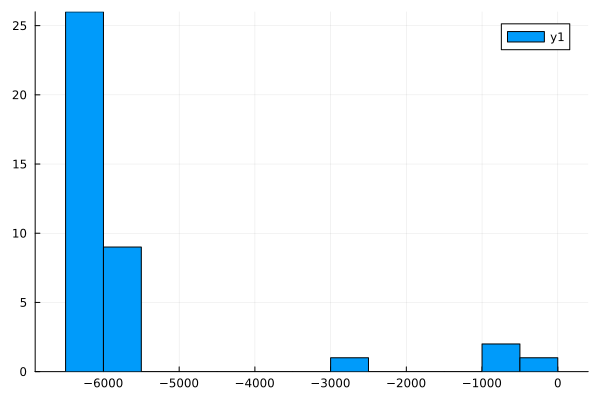

In [561]:
histogram([el[2] for el in test])

In [579]:
[allres[!,"graphname"].=="G56.zip"]

1-element Vector{BitVector}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [588]:
@subset(allres, findall(x -> x.=="G56.zip", :graphname))

LoadError: ArgumentError: length 185 of vector returned from function #611 is different from number of rows 609760 of the source data frame.

In [595]:
objs = allres[[allres[!,"graphname"].=="G56.zip"][1], 6]

185-element Vector{Float64}:
 3952.0
 3969.0
 3982.0
 3963.0
 3965.0
 3500.0
 3494.0
 3493.0
 3483.0
 3510.0
 3661.0
 3650.0
 3718.0
    ⋮
 3529.0
 3628.0
 3547.0
 3536.0
 3518.0
 3615.0
 3562.0
 3590.0
 3579.0
 3543.0
 3575.0
 3608.0

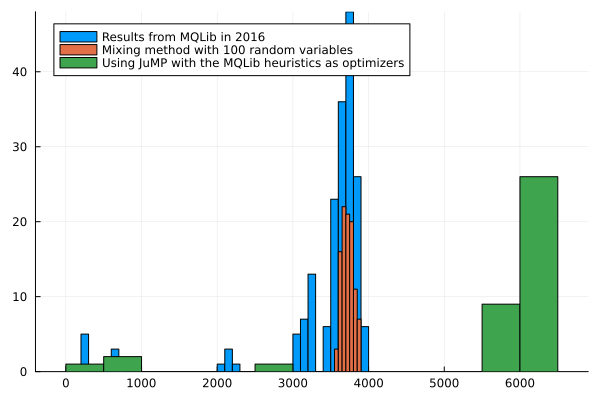

In [602]:
histogram(objs, label="Results from MQLib in 2016")
histogram!(-Mixing.assign100(V,  matrixFromFile(G56)), label="Mixing method with 100 random variables")
histogram!(-[el[2] for el in test], label="Using JuMP with the MQLib heuristics as optimizers", legend=:topleft)